In [5]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.insert(1, '../../../sibyl')

In [2]:
from sklearn.model_selection import train_test_split

x_orig = pd.read_csv(os.path.join("data", "train.csv"))
y = x_orig["Survived"]
x_orig = x_orig.drop("Survived", axis="columns")

x_orig_train, x_orig_test, y_train, y_test = train_test_split(x_orig, y, test_size=.20)

print("Features:", x_orig.columns.values)

feature_descriptions = {
    "PassengerId": "Passenger ID",
    "Pclass": "Ticket Class",
    "SibSp": "Number of siblings/spouses aboard",
    "Parch": "Number of parents/children aboard",
    "Ticket": "Ticket Number",
    "Fare": "Passenger Fare",
    "Cabin": "Cabin Number",
    "Embarked": "Port of Embarkment",
}

Features: ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [3]:
from sklearn.impute import SimpleImputer

class ColumnDropTransformer:
    """
    Removes columns that should not be predictive
    """
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
        
    def transform(self, x):
        return x.drop(self.columns_to_drop, axis="columns")
    
    def transform_contributions(self, contributions):
        for col in self.columns_to_drop:
            contributions[col] = 0
        return contributions
            
class MultiTypeImputer:
    """
    Imputes, chosing a strategy based on column type.
    """
    def __init__(self):
        self.numeric_cols = None
        self.categorical_cols = None
        self.numeric_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
        self.categorical_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
        
    def fit(self, x):
        self.numeric_cols = x.select_dtypes(include="number").columns
        self.categorical_cols = x.select_dtypes(exclude="number").columns
        self.numeric_imputer.fit(x[self.numeric_cols])
        self.categorical_imputer.fit(x[self.categorical_cols])
    
    def transform(self, x):
        new_numeric_cols = self.numeric_imputer.transform(x[self.numeric_cols])
        new_categorical_cols = self.categorical_imputer.transform(x[self.categorical_cols])
        return pd.concat([pd.DataFrame(new_numeric_cols, columns=self.numeric_cols, index=x.index), 
                          pd.DataFrame(new_categorical_cols, columns=self.categorical_cols, index=x.index)], axis=1)

In [6]:
from real.utils.transformer import OneHotEncoderWrapper, fit_transformers, run_transformers

column_drop = ColumnDropTransformer(["PassengerId", "Name", "Ticket", "Cabin"])
imputer = MultiTypeImputer()
one_hot_encoder = OneHotEncoderWrapper(["Sex", "Embarked"])

transformers = [column_drop, imputer, one_hot_encoder]
fit_transformers(transformers, x_orig_train)
x_transform_train = run_transformers(transformers, x_orig_train)
x_transform_test = run_transformers(transformers, x_orig_test)

In [7]:
from sklearn.linear_model import LogisticRegression
import pickle

model = LogisticRegression(max_iter=500)
model.fit(x_transform_train, y_train)

preds = model.predict(x_transform_test)
print("Test accuracy: %.2f" % (np.mean(preds==y_test)*100))

Test accuracy: 83.24


In [8]:
from real.explainers import LocalFeatureContribution

lfc = LocalFeatureContribution(model=model, x_orig=x_orig_train, m_transforms=transformers, e_transforms=transformers, 
                               contribution_transforms=[one_hot_encoder, column_drop], 
                               feature_descriptions=feature_descriptions, fit_on_init=True)

PassengerId                       426
Pclass                              3
Name           Wiseman, Mr. Phillippe
Sex                              male
Age                               NaN
SibSp                               0
Parch                               0
Ticket                     A/4. 34244
Fare                             7.25
Cabin                             NaN
Embarked                            S
Name: 425, dtype: object


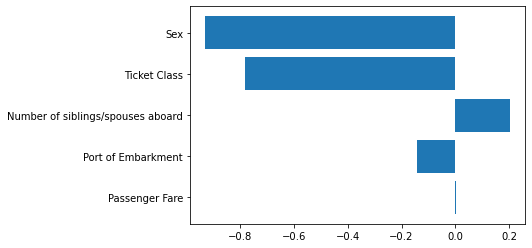

In [9]:
import importlib
from real.utils import visualize
importlib.reload(visualize)

contributions = lfc.produce(x_orig_test.iloc[0])
print(x_orig_test.iloc[0])

visualize.plot_top_contributors(contributions, select_by="absolute")

In [10]:
pickle.dump(model, open("model.pkl", "wb"))
pickle.dump(transformers, open("transformers.pkl", "wb"))